In [11]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Final Assessment


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Final Assessment


###(a) When and by whom was the dataset created?
    The dataset was created by Nikhil Kumar.

###(b) How did you access the dataset?
    The dataset was accessed through Kaggle, an online platform that provides a repository of datasets for machine learning and data analysis.

###(c) How does it align with the chosen UNSDG?
    This dataset aligns with the United Nations Sustainable Development Goal (UNSDG) 4: Quality Education. It focuses on student performance and retention, analyzing various educational factors that influence academic success. By studying these factors, the dataset contributes to understanding and improving education quality, equity, and accessibility.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from math import sqrt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [13]:
df = pd.read_csv("Student_Performance.csv")

#EDA

##Data Overview

In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB
None


In [15]:
print(df.head())

   Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  


In [16]:
print("\nColumns and their data types:")
df.dtypes


Columns and their data types:


,0
Hours Studied,int64
Previous Scores,int64
Extracurricular Activities,object
Sleep Hours,int64
Sample Question Papers Practiced,int64
Performance Index,float64


In [17]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


In [18]:
print("\nNumber of Duplicated Rows:", df.duplicated().sum())
df = df.drop_duplicates(keep='first')


Number of Duplicated Rows: 127


2. Summary Statistics

In [19]:
print(df.describe())

       Hours Studied  Previous Scores  Sleep Hours  \
count    9873.000000      9873.000000  9873.000000   
mean        4.992100        69.441102     6.531652   
std         2.589081        17.325601     1.697683   
min         1.000000        40.000000     4.000000   
25%         3.000000        54.000000     5.000000   
50%         5.000000        69.000000     7.000000   
75%         7.000000        85.000000     8.000000   
max         9.000000        99.000000     9.000000   

       Sample Question Papers Practiced  Performance Index  
count                       9873.000000        9873.000000  
mean                           4.583004          55.216651  
std                            2.867202          19.208570  
min                            0.000000          10.000000  
25%                            2.000000          40.000000  
50%                            5.000000          55.000000  
75%                            7.000000          70.000000  
max                      

##Scatter Plot

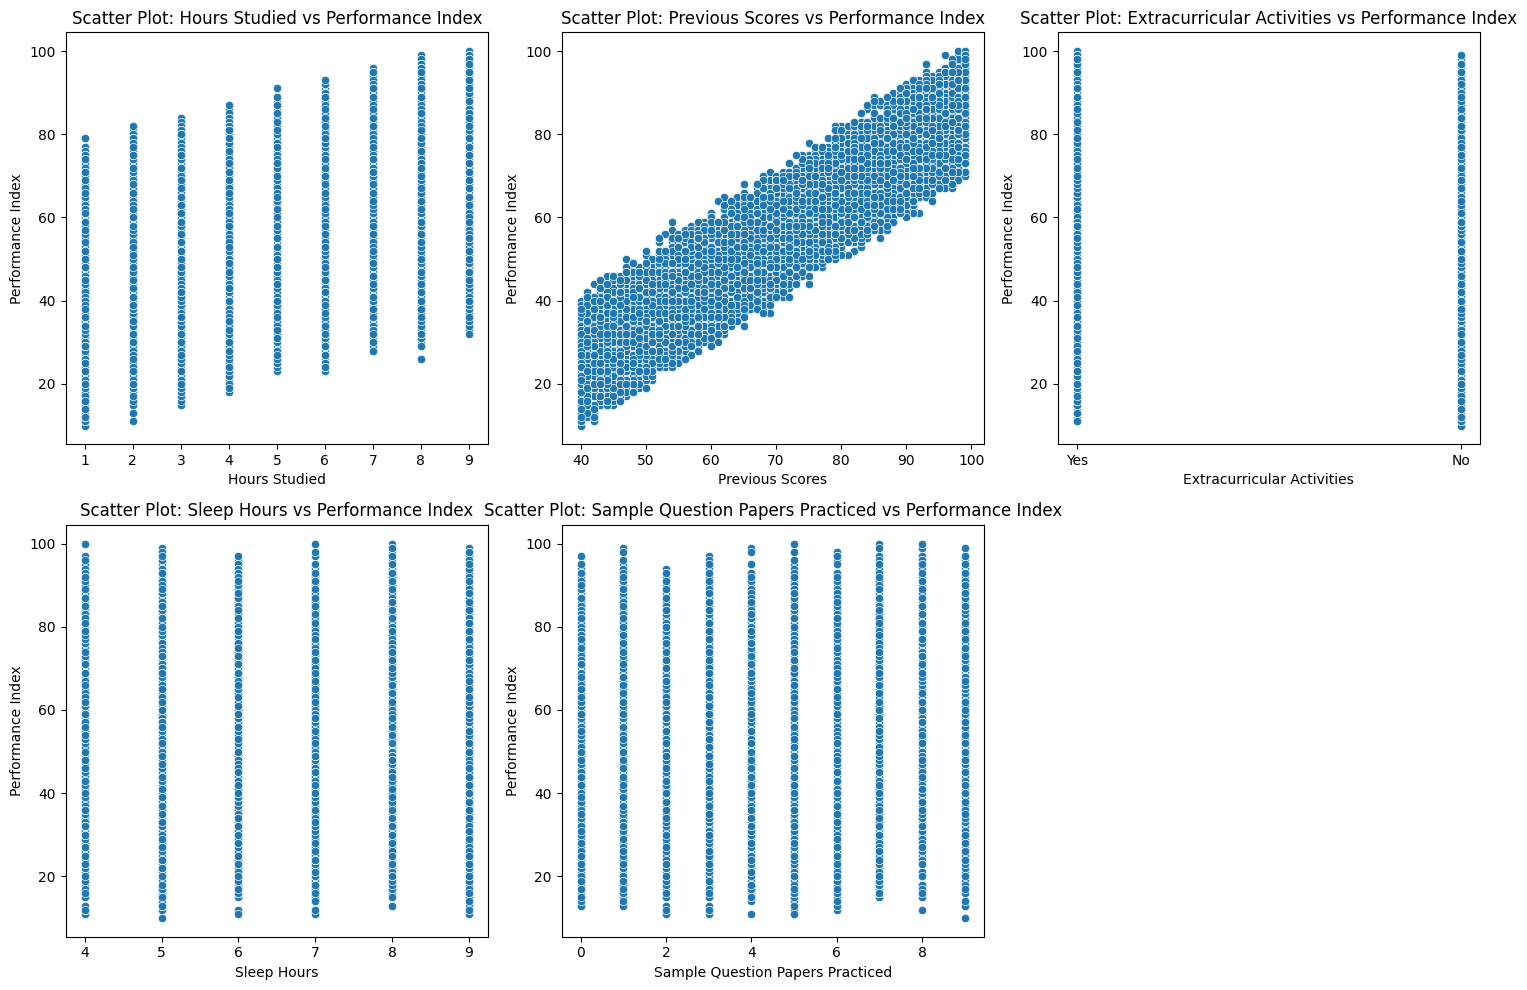

In [20]:
features = ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=df[feature], y=df['Performance Index'])
    plt.title(f'Scatter Plot: {feature} vs Performance Index')
    plt.xlabel(feature)
    plt.ylabel('Performance Index')

plt.tight_layout()
plt.show()


## Correlation Matrix

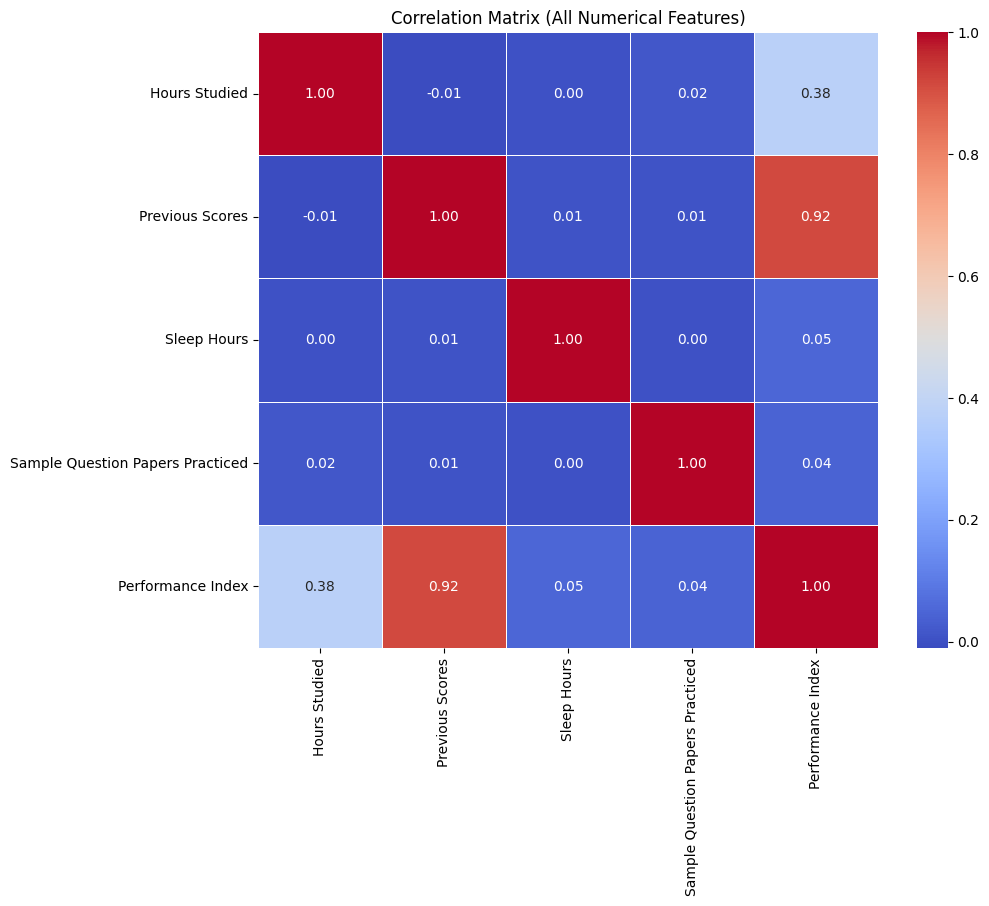

In [21]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix (All Numerical Features)")
plt.show()


##Histograms

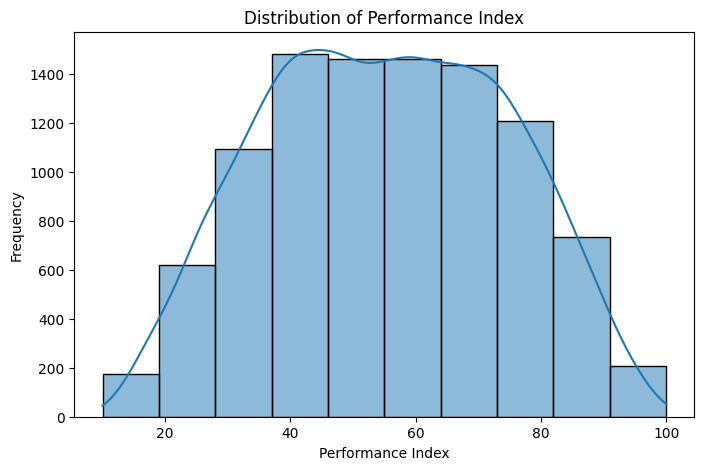

In [22]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Performance Index"], bins=10, kde=True)
plt.title("Distribution of Performance Index")
plt.xlabel("Performance Index")
plt.ylabel("Frequency")
plt.show()


5. Categorical and Numeric Features Analysis

In [23]:
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

print("\nCategorical Columns:", list(categorical_cols))
print("Numerical Columns:", list(numerical_cols))


Categorical Columns: ['Extracurricular Activities']
Numerical Columns: ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']


<Figure size 1500x1000 with 0 Axes>

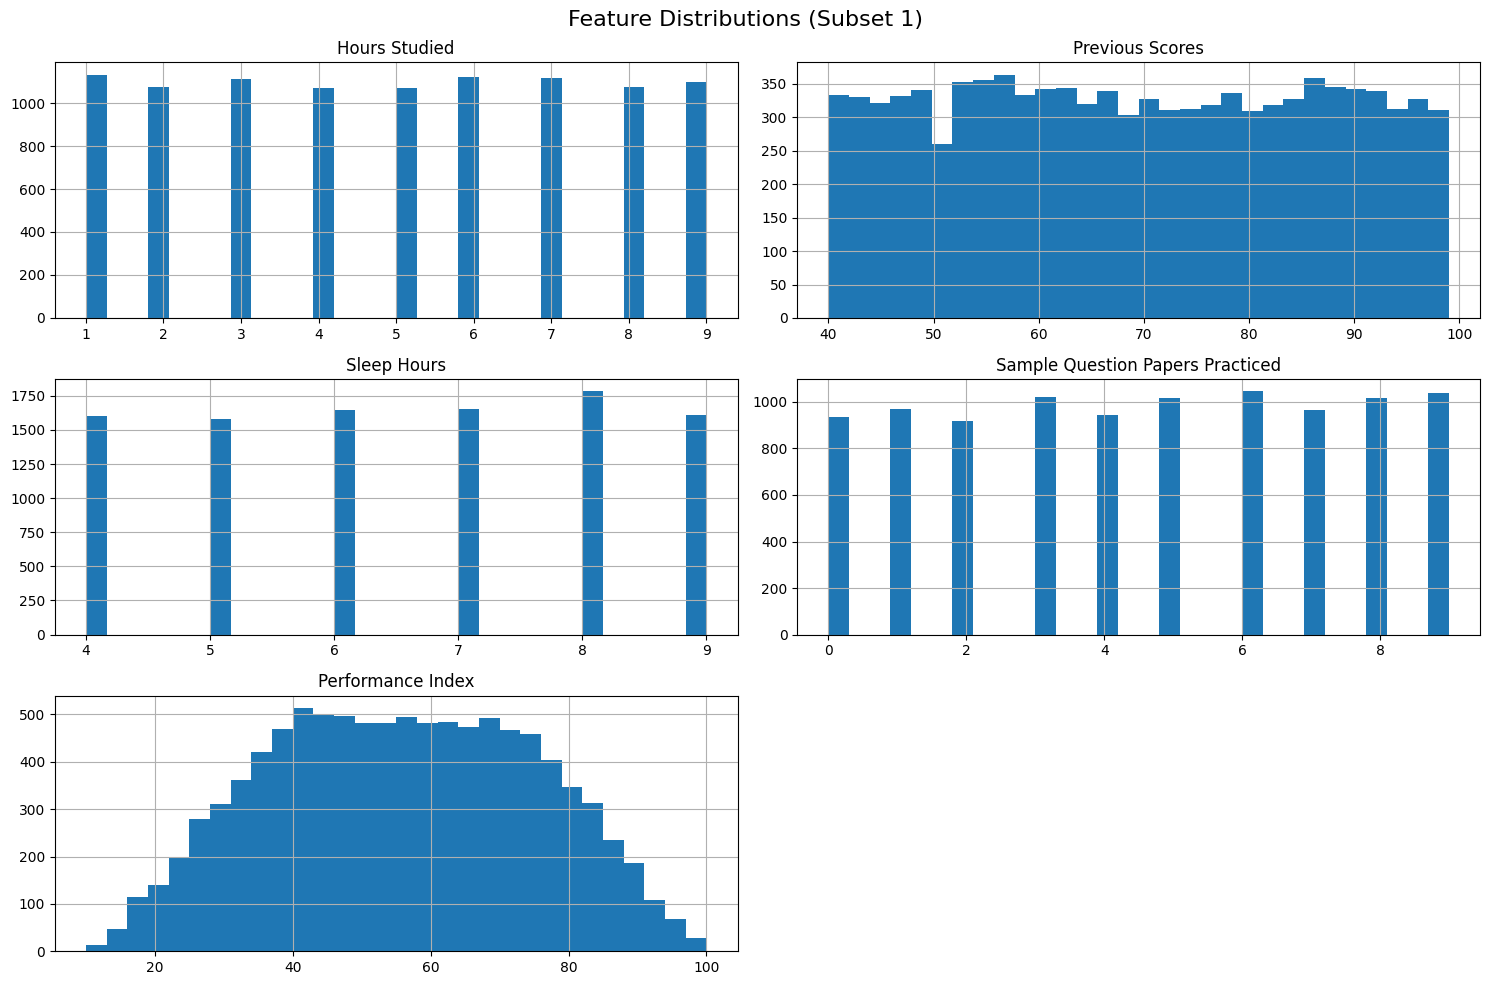

In [24]:
categorical_cols = ['Extracurricular Activities']  # Update as needed
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

chunk_size = 10
numerical_cols = df_encoded.select_dtypes(include='number').columns

for i in range(0, len(numerical_cols), chunk_size):
    subset = numerical_cols[i:i+chunk_size]

    plt.figure(figsize=(15, 10))

    df_encoded[subset].hist(figsize=(15, 10), bins=30)

    plt.xticks(rotation=45, ha='right')

    plt.suptitle(f"Feature Distributions (Subset {i//chunk_size + 1})", fontsize=16)
    plt.tight_layout()

    plt.show()


##Boxplot

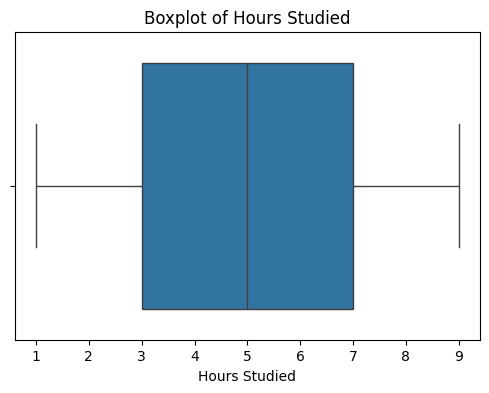

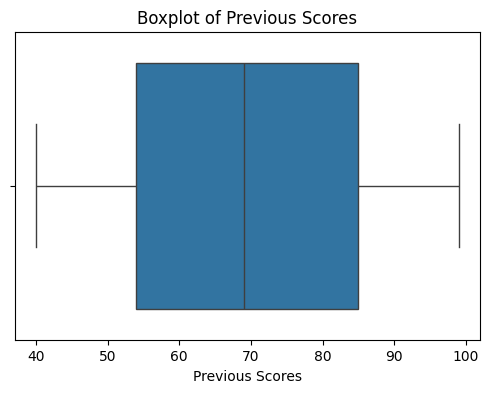

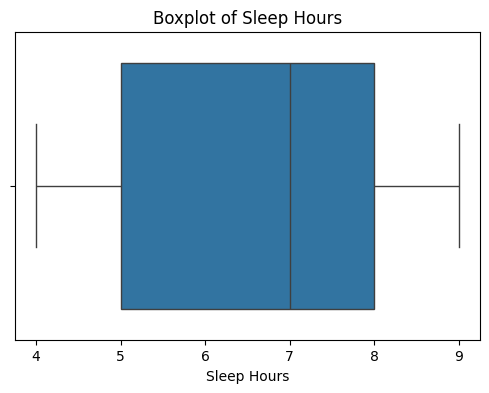

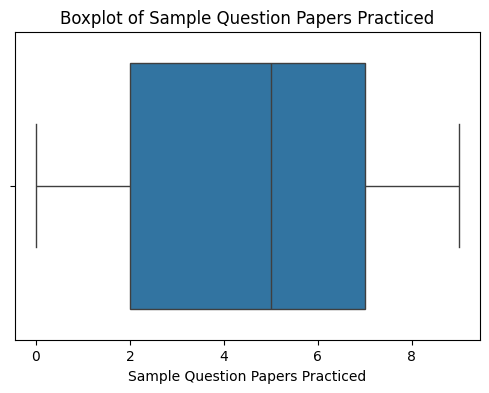

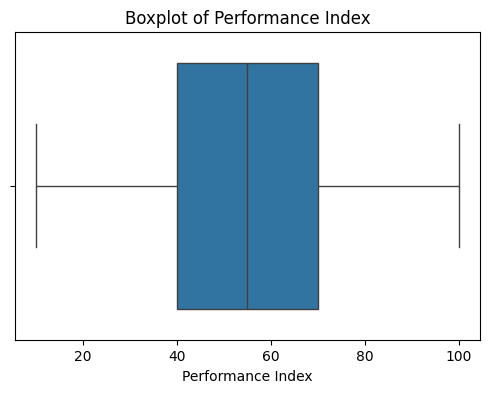

In [25]:
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


## Outlier Detection (Using Z-score)

In [26]:
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).sum(axis=0)
print("\nPotential Outliers in Each Feature:\n", outliers)


Potential Outliers in Each Feature:
 Hours Studied                       0
Previous Scores                     0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


##Pair plot


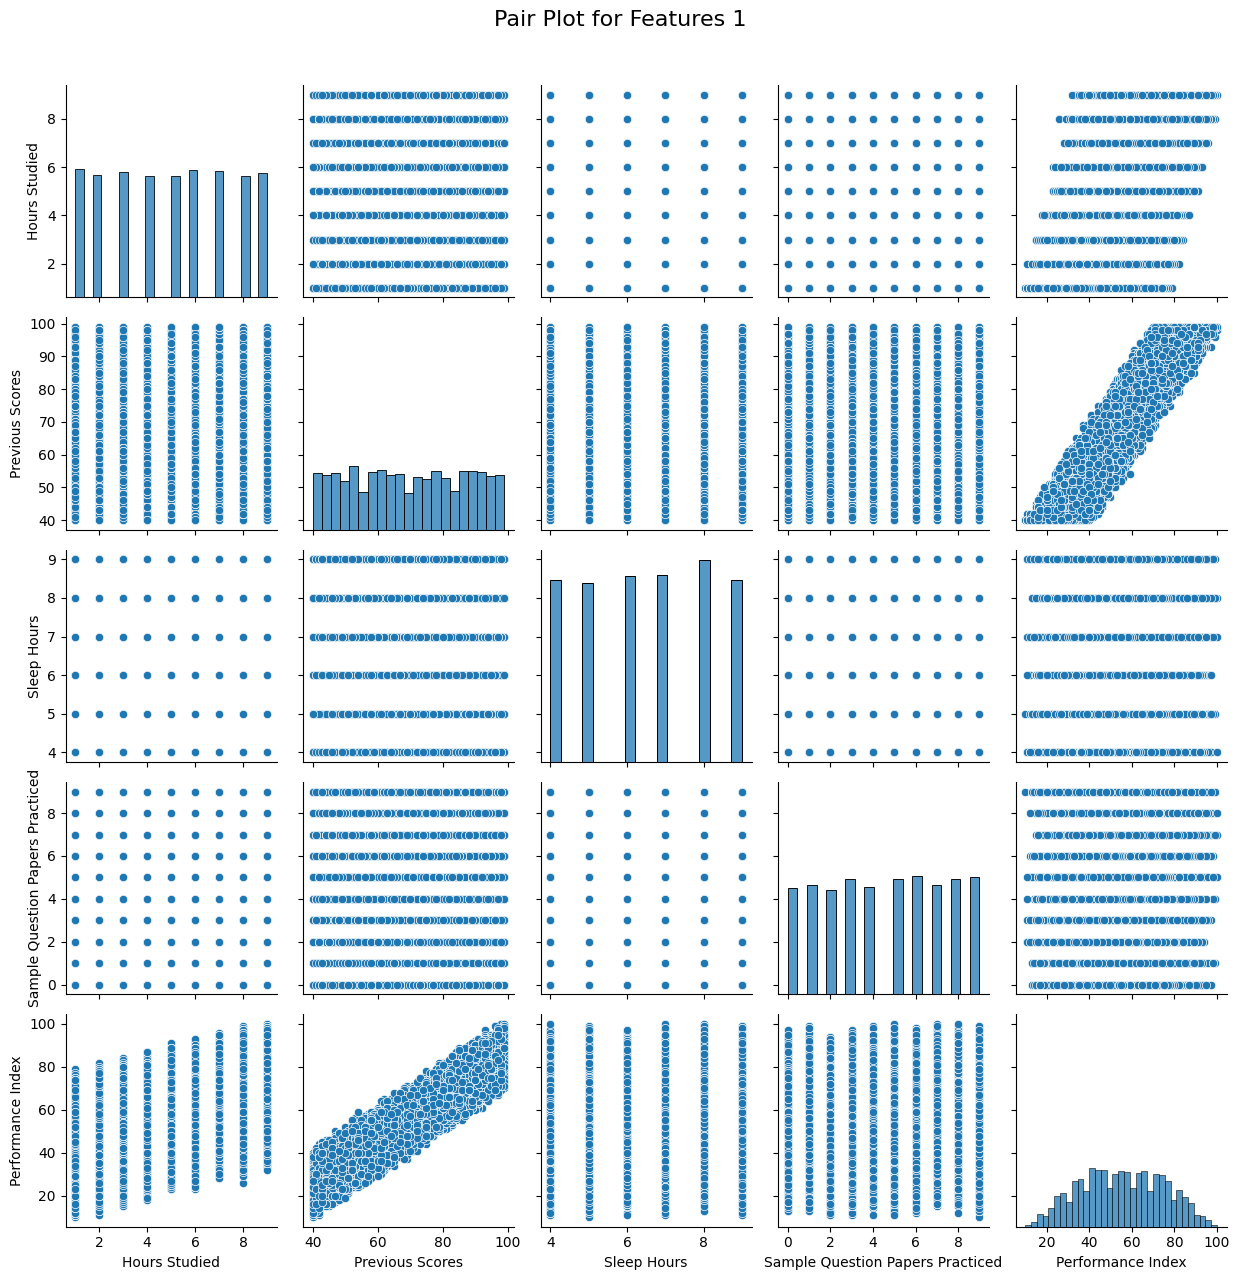

In [27]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

batch_size = 6

num_batches = len(numerical_cols) // batch_size + (len(numerical_cols) % batch_size > 0)
for i in range(num_batches):
    subset_cols = numerical_cols[i * batch_size : (i + 1) * batch_size]

    if len(subset_cols) > 1:
        sns.pairplot(df[subset_cols])
        plt.suptitle(f"Pair Plot for Features {i+1}", y=1.02, fontsize=16)
        plt.tight_layout()
        plt.show()


# 2. Build a Model from Scratch [5]:


In [28]:
  df['Extracurricular Activities'] = df['Extracurricular Activities'].apply(lambda x: 1 if x == 'Yes' else 0)

  X = df[['Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']]
  y = df['Performance Index']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  class LinearRegressionScratch:
      def __init__(self):
          self.theta = None

      def fit(self, X, y):
          X = np.c_[np.ones(X.shape[0]), X]
          self.theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)

      def predict(self, X):
          X = np.c_[np.ones(X.shape[0]), X]
          return X.dot(self.theta)

  model = LinearRegressionScratch()
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  rmse = sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print(f"Mean Squared Error from scratch: {mse}")
  print(f"Root Mean Squared Error from scratch: {rmse}")
  print(f"Mean Absolute Error from scratch: {mae}")
  print(f"R-squared from scratch: {r2}")


Mean Squared Error from scratch: 59.6002030279187
Root Mean Squared Error from scratch: 7.72011677553641
Mean Absolute Error from scratch: 6.657542982539004
R-squared from scratch: 0.8398553176940322


#3. Build a Primary Model (Linear Regression & Random Forest Regressor)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_linear = linear_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"Evaluation for {model_name} using sklearn:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared: {r2}")
    print("-" * 40)

evaluate_model(y_test, y_pred_linear, "Linear Regression")

evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")


Evaluation for Linear Regression using sklearn:
Mean Absolute Error (MAE): 6.657542982539013
Mean Squared Error (MSE): 59.60020302791905
Root Mean Squared Error (RMSE): 7.720116775536433
R-squared: 0.8398553176940313
----------------------------------------
Evaluation for Random Forest Regressor using sklearn:
Mean Absolute Error (MAE): 7.2721685678175545
Mean Squared Error (MSE): 77.3102286782169
Root Mean Squared Error (RMSE): 8.792623537842212
R-squared: 0.7922687947073741
----------------------------------------


**Summary:**


Linear Regression outperforms Random Forest Regressor on this dataset in terms of MAE, MSE, RMSE, and R-squared. While Random Forest might be more powerful in capturing complex relationships, Linear Regression seems to provide better overall predictive accuracy and lower error in this case. The choice of Linear Regression can be justified by its simplicity, interpretability, and superior performance on the provided metrics.

# 4. Hyper-parameter Optimization with Cross-Validation [2.5]:


In [30]:
linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)

linear_params = {
    'fit_intercept': [True, False]
}

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_lr = GridSearchCV(linear_model, linear_params, cv=5, scoring='r2', n_jobs=-1)
grid_search_lr.fit(X, y)

grid_search_rf = GridSearchCV(rf_model, rf_params, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X, y)

best_lr_params = grid_search_lr.best_params_
best_rf_params = grid_search_rf.best_params_

print(f"Best Hyperparameters for Linear Regression: {best_lr_params}")
print(f"Best Hyperparameters for Random Forest: {best_rf_params}")


Best Hyperparameters for Linear Regression: {'fit_intercept': True}
Best Hyperparameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


**Summary**

**For Linear Regression**, the key hyperparameter is fit_intercept=True, indicating the model will include an intercept term.

**For Random Forest**, the optimal hyperparameters are max_depth=5, min_samples_leaf=1, min_samples_split=2, and n_estimators=100, which balance model complexity and accuracy.

#5. Feature selection
**embedded method Lasso (L1 Regularization)**

In [31]:
  lasso = Lasso(alpha=0.01)

  lasso.fit(X, y)

  selected_features = X.columns[np.abs(lasso.coef_) > 0]
  print(f"Selected Features using Lasso: {selected_features.tolist()}")


Selected Features using Lasso: ['Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']


**Summary:**


By using Lasso(Least Absolute Shrinkage and Selection Operator)  with an alpha of 0.01, the selected features are those with the greatest impact on predicting the target variable, as indicated by their non-zero coefficients. Lasso is an embedded method for feature selection, meaning it performs both model fitting and feature selection simultaneously during the training process. By applying L1 regularization, Lasso adds a penalty to the absolute values of the coefficients, forcing some to become exactly zero. This effectively eliminates irrelevant or less important features from the model, reducing overfitting and improving generalization. Ultimately, Lasso helps streamline the model by retaining only the most significant features, enhancing both interpretability and performance.








# 6. Final Model [2.5]:


In [32]:
X_selected = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

best_lr_params = grid_search_lr.best_params_

final_lr_model = LinearRegression(**best_lr_params)
final_lr_model.fit(X_train, y_train)

y_pred_lr = final_lr_model.predict(X_test)

best_rf_params = grid_search_rf.best_params_

final_rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
final_rf_model.fit(X_train, y_train)

y_pred_rf = final_rf_model.predict(X_test)

def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Performance Metrics for {model_name}:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared (R²): {r2}\n")

evaluate_model(y_test, y_pred_lr, "Final Linear Regression")

evaluate_model(y_test, y_pred_rf, "Final Random Forest")


Performance Metrics for Final Linear Regression:
Mean Absolute Error (MAE): 6.657542982539013
Root Mean Squared Error (RMSE): 7.720116775536433
Mean Squared Error (MSE): 59.60020302791905
R-squared (R²): 0.8398553176940313

Performance Metrics for Final Random Forest:
Mean Absolute Error (MAE): 6.698046890524359
Root Mean Squared Error (RMSE): 7.789488234138816
Mean Squared Error (MSE): 60.676126949787054
R-squared (R²): 0.8369643293097765



**Summary:**
Linear Regression slightly outperforms Random Forest in all performance metrics (MAE, RMSE, MSE, and R²), with marginally lower errors and a higher R² value. Both models explain similar proportions of variance, but Linear Regression offers better accuracy and is simpler and more interpretable. While Random Forest is more flexible, the small performance difference suggests Linear Regression is the better choice for this dataset.

#7. Conclusion [2.5]:

1. **Model Performance**:  
   The **Linear Regression** model performed slightly better than the **Random Forest Regressor** across all key metrics (Mean Absolute Error, Root Mean Squared Error, Mean Squared Error, and R-squared). Linear Regression showed lower errors and a higher R-squared, suggesting more accurate and reliable predictions. Both models performed well, but Linear Regression's simplicity and interpretability made it the preferred choice for this dataset.

2. **Impact of Methods**:  
   The **Feature Selection** technique, particularly using **Lasso (L1 regularization)**, helped in identifying the most important features, streamlining the model, and improving generalization by reducing overfitting. The use of **Cross-Validation** helped ensure the models were robust and not overfitting to the training data, improving overall performance and reliability. Both techniques contributed positively to the models by simplifying feature space and enhancing generalization.

3. **Insights and Future Directions**:  
   The experiment highlighted the importance of selecting the right features and tuning models for better predictive performance. **Linear Regression** emerged as a simpler, more effective model for this problem, but exploring more complex models like **Random Forest** and **Gradient Boosting** might further enhance performance. Future work could involve experimenting with hyperparameter tuning, additional feature engineering, and testing on different datasets to evaluate model robustness.